In [1]:
#mount google drive so it is accessible in notebook - you can skip this and just download the dataset to local Colab folder
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


##**Introduction:**
The objective of this notebook is to explore and analyse the census-income dataset for any bias and or unfairness. This dataset is very popular in the ML community, being manipulated and implemented in a plethora of use-cases. One of the most popular use-cases for the dataset is in the classification task of classifying whether an individual will earn >50k per annum and it is this task that will be explored in the notebook. A range of classifiers are explored and tuned in order to find the optimal algorithm and its associated parameters for the task at hand. The dataset is made up of an arrangement of sensitive/protected attributes that may have an effect on the final classification, be it a positive or negative classification. In the notebook we will explore more the negative implications of the classification results and aim to quantify the bias and unfairness that may arise from the data.

## **Part 1: Loading and pre-processing dataset**
In this section, the required training and test datasets are acquired and loaded from the machine learning repository website. Pre-processing is an essential pre-cursor in any ML task and is carried out to remove any missing or NA values, enode the target variable as categorical, clean some of the attributes to reduce their data verbosity including combining columns into 1 or reducing the number of categorical values of an attribute. 

In [1]:
#installing all dependancies and required packages from requirements.txt
!pip install -r requirements.txt

In [2]:
#import dependancies
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import warnings
import random
random.seed(100)
warnings.filterwarnings('ignore') #ignore any warnings

In [4]:
dataset_name = "adult_data.csv"
test_name = "adult_test.csv"
names_name = "adult_name.csv"
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
names_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
dir_path = "/content/drive/My Drive/"

#download train and test data and store in Google Drive
def download_data():
    if not os.path.isfile(os.path.join("/content/drive/My Drive","adult_data.csv")):

          try:
          #get data from url
            r = requests.get(data_url, allow_redirects = True) #error handling, if response == 200
            r.raise_for_status()    #if response status code != 200

            source_path = (os.path.join(dir_path, dataset_name))

            #open local file
            open(source_path, 'wb').write(r.content)
          except OSError:
                raise OSError('Error downloading dataset\n')

    if not os.path.isfile(os.path.join("/content/drive/My Drive","adult_test.csv")):

          try:
          #get data from url
            r = requests.get(test_url, allow_redirects = True) #error handling, if response == 200
            r.raise_for_status()    #if response status code != 200

            source_path = (os.path.join(dir_path, test_name))

            #open local file
            open(source_path, 'wb').write(r.content)
          except OSError:
             raise OSError('Error downloading dataset\n')

    if not os.path.isfile(os.path.join("/content/drive/My Drive","adult_names.csv")):

        try:
        #get data from url
          r = requests.get(names_url, allow_redirects = True) #error handling, if response == 200
          r.raise_for_status()    #if response status code != 200

          source_path = (os.path.join(dir_path, names_name))

          #open local file
          open(source_path, 'wb').write(r.content)
        except OSError:
            raise OSError('Error downloading dataset\n')



#download train and test data and store locally, if drive not mounted
def download_data_unmounted():

      try:
      #get data from url
        r = requests.get(data_url, allow_redirects = True) #error handling, if response == 200
        r.raise_for_status()    #if response status code != 200

        #open local file
        open(dataset_name, 'wb').write(r.content)
      except OSError:
            print('Error downloading dataset\n')

      try:
      #get data from url
        r = requests.get(test_url, allow_redirects = True) #error handling, if response == 200
        r.raise_for_status()    #if response status code != 200

        #open local file
        open(test_name, 'wb').write(r.content)
      except OSError:
          print('Error downloading dataset\n')

      try:
      #get data from url
        r = requests.get(names_url, allow_redirects = True) #error handling, if response == 200
        r.raise_for_status()    #if response status code != 200

        #open local file
        open(names_name, 'wb').write(r.content)
      except OSError:
          print('Error downloading dataset\n')

In [5]:
#try downloading data to google drive if it is mounted, if not then just download datasets locally
try:
  download_data()
except:
  download_data_unmounted()

In [6]:
#copy data from Google drive to cwd

!cp "/content/drive/My Drive/adult_data.csv" "adult_train"
!cp "/content/drive/My Drive/adult_test.csv" "adult_test"
!cp "/content/drive/My Drive/adult.csv" "adult"
!cp "adult_data.csv" "adult_train"
!cp "adult_test.csv" "adult_test"

cp: cannot stat '/content/drive/My Drive/adult.csv': No such file or directory
cp: cannot stat 'adult_data.csv': No such file or directory
cp: cannot stat 'adult_test.csv': No such file or directory


In [7]:
!ls

adult_test  adult_train  drive	requirements.txt  sample_data


In [8]:
#import dataset as pandas DataFrame, setting any NA values to '?'
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
          
train_adult = pd.read_csv("adult_train", names=columns, sep=' *, *', na_values='?')
test_adult = pd.read_csv("adult_test", names=columns, sep=' *, *', skiprows=1,na_values='?')

In [9]:
test_adult.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [10]:
#get dataset shape 
print('Train Shape: ', train_adult.shape)
print('Test Shape: ', test_adult.shape)

Train Shape:  (32561, 15)
Test Shape:  (16281, 15)


In [11]:
#get dataset info 
train_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [12]:
#replacing any missing values with the mode (most common value) of the column 
train_adult['occupation'] = train_adult['occupation'].fillna('Prof-specialty')
train_adult['workClass'] = train_adult['workClass'].fillna('Private')
train_adult['native-country'] = train_adult['native-country'].fillna('United-States')

#replacing any missing values with the mode (most common value) of the column 
test_adult['occupation'] = test_adult['occupation'].fillna('Prof-specialty')
test_adult['workClass'] = test_adult['workClass'].fillna('Private')
test_adult['native-country'] = test_adult['native-country'].fillna('United-States')


In [13]:
train_adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [14]:
test_adult['income']

0        <=50K.
1        <=50K.
2         >50K.
3         >50K.
4        <=50K.
          ...  
16276    <=50K.
16277    <=50K.
16278    <=50K.
16279    <=50K.
16280     >50K.
Name: income, Length: 16281, dtype: object

In [15]:
train_adult['income']

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income, Length: 32561, dtype: object

In [16]:
#transforming income target variable into categorical binary form where 0 is <=50k, 1 is >50k 
train_adult['income']=train_adult['income'].map({'<=50K': 0, '>50K': 1})
test_adult['income']=test_adult['income'].map({'<=50K.': 0, '>50K.': 1}) #for test data, ensure there is '.' at end of row entries, '<=50k.' not <=50k'


In [17]:
#Creating Capital difference column which is gain - loss 
train_adult['capital-diff'] = train_adult['capital-gain'] - train_adult['capital-loss']
train_adult.drop(['capital-loss'], axis = 1, inplace = True)
train_adult.drop(['capital-gain'], axis = 1, inplace = True)

#Creating Capital difference column which is gain - loss 
test_adult['capital-diff'] = test_adult['capital-gain'] - test_adult['capital-loss']
test_adult.drop(['capital-loss'], axis = 1, inplace = True)
test_adult.drop(['capital-gain'], axis = 1, inplace = True)

In [18]:
#dropping education number column as it is just a numerical representation of the education column
train_adult.drop(['education-num'], axis = 1, inplace = True)

#updating education column to combine several categories into one, removing verbose categories 
train_adult['education'].replace(['5th-6th', '1st-4th', 'Preschool'],
                             'Primary School', inplace = True)

train_adult['education'].replace(['7th-8th', '9th','10th','11th','12th'],
                             'Secondary School', inplace = True)

test_adult.drop(['education-num'], axis = 1, inplace = True)
test_adult['education'].replace(['5th-6th', '1st-4th', 'Preschool'],
                             'Primary School', inplace = True)

test_adult['education'].replace(['7th-8th', '9th','10th','11th','12th'],
                             'Secondary School', inplace = True)

train_adult['education'].value_counts()

HS-grad             10501
Some-college         7291
Bachelors            5355
Secondary School     3701
Masters              1723
Assoc-voc            1382
Assoc-acdm           1067
Prof-school           576
Primary School        552
Doctorate             413
Name: education, dtype: int64

In [19]:
#splitting age into 9 bins of 10 years each (except for 17-20 bin) categories of 
train_adult['age'] = pd.cut(train_adult['age'], bins = [17, 20, 31, 40, 51, 60, 71, 80, 91, 100], labels = ['17-20', '21-30', '31-40','41-50','51-60','61-70','71-80','81-90','91-100'])
test_adult['age'] = pd.cut(test_adult['age'], bins = [17, 20, 31, 40, 51, 60, 71, 80, 91, 100], labels = ['17-20', '21-30', '31-40','41-50','51-60','61-70','71-80','81-90','91-100'])

In [20]:
#Split hours-per-week column into various bins to reduce 1-100 hour spread 
train_adult['hours-per-week'] = pd.cut(train_adult['hours-per-week'], 
                                   bins = [0, 30, 45, 100], 
                                   labels = ['Lesser Working Week', 'Normal Working Week', 'Extra Working Week'])
test_adult['hours-per-week'] = pd.cut(test_adult['hours-per-week'], 
                                   bins = [0, 30, 45, 100], 
                                   labels = ['Lesser Working Week', 'Normal Working Week', 'Extra Working Week'])


In [21]:
#as can be seen from the above plot, the data is largely skewed by the amount of 'United-States' entries for the native-country column,
#seperating the attribute into 'United-States' and 'Other' should account for this and skew the data less 

count = train_adult['native-country'].value_counts()
countries = np.array(train_adult['native-country'].unique())
countries = np.delete(countries, 0)

train_adult['native-country'].replace(countries, 'Other', inplace = True)

count = test_adult['native-country'].value_counts()
countries = np.array(test_adult['native-country'].unique())
countries = np.delete(countries, 0)

test_adult['native-country'].replace(countries, 'Other', inplace = True)

In [22]:
train_adult.head()

,age,workClass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,31-40,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Normal Working Week,United-States,0,2174
1,41-50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,Lesser Working Week,United-States,0,0
2,31-40,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,Normal Working Week,United-States,0,0
3,51-60,Private,234721,Secondary School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,Normal Working Week,United-States,0,0
4,21-30,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Normal Working Week,Other,0,0


In [23]:
test_adult.head()

,age,workClass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,21-30,Private,226802,Secondary School,Never-married,Machine-op-inspct,Own-child,Black,Male,Normal Working Week,United-States,0,0
1,31-40,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,Extra Working Week,United-States,0,0
2,21-30,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,Normal Working Week,United-States,1,0
3,41-50,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,Normal Working Week,United-States,1,7688
4,17-20,Private,103497,Some-college,Never-married,Prof-specialty,Own-child,White,Female,Lesser Working Week,United-States,0,0


## **Part 2: Exploratory Analysis of dataset**
In this section we explore the different attributes and their makeup and distribution within the dataset through a variety of visualisations. This process will assist in identifying any visible patterns in the dataset there may be, assisting in the classifcation and bias evaluation process. Firstly, income will be compared against any of the non-sensitive/non-protected attributes, followed by the analysis of protected attributes.

In [24]:
#Plots for age, captial difference, education number and hours per week distribution in dataset as well as their mean
# xaxes = ['age','capital difference','hours per week']
# yaxes = 'Frequency'
# titles = ['Age Distribution','Capital Difference Distribution','Hours per week Distribution'] 
# cols = ['age','capital-diff','hours-per-week']

# f,a = plt.subplots(3, figsize=(12,6))
# a = a.ravel()
# for idx,ax in enumerate(a):
#     ax.hist(train_adult[cols[idx]])   #possible error when executing but that's ok 
#     ax.set_title(titles[idx])
#     ax.set_xlabel(xaxes[idx])
#     ax.set_ylabel(yaxes[idx])
#     ax.axvline(train_adult[cols[idx]].mean(),color='peru', linestyle='dashed',linewidth=3)
# plt.tight_layout()

Text(0.5, 1.0, 'Education per sex')

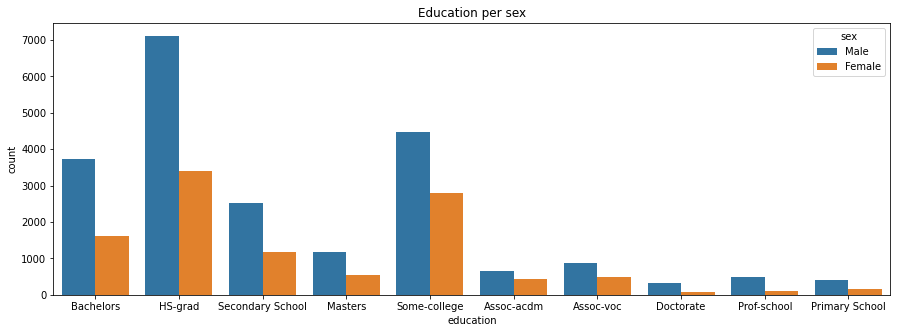

In [25]:
#education per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'education', hue = 'sex', data = train_adult)
plt.title('Education per sex')

Text(0.5, 1.0, 'Workclass per sex')

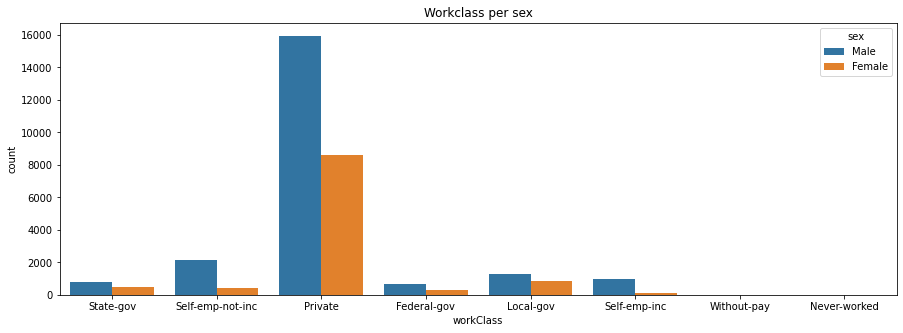

In [26]:
#workClass per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'workClass', hue = 'sex', data = train_adult)
plt.title('Workclass per sex')

Text(0.5, 1.0, 'Occupation per sex')

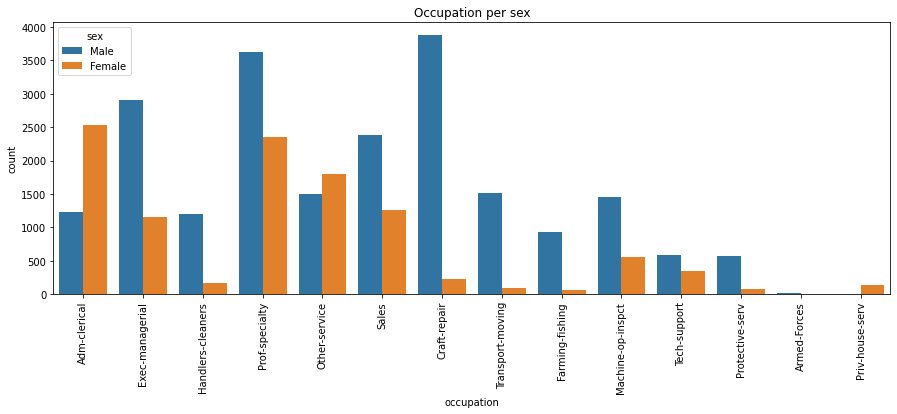

In [27]:
#occupation per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'occupation', hue = 'sex', data = train_adult)
plt.xticks(rotation=90)
plt.title('Occupation per sex')

Text(0.5, 1.0, 'Native-country per sex')

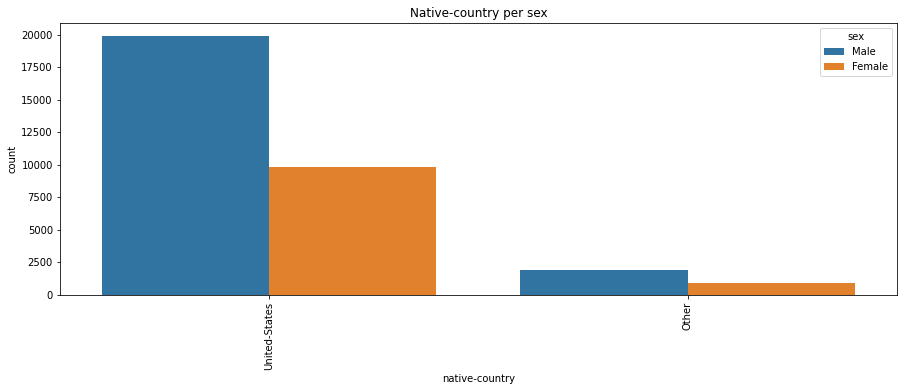

In [28]:
#native-country per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'native-country', hue = 'sex', data = train_adult)
plt.xticks(rotation=90)
plt.title('Native-country per sex')

Text(0.5, 1.0, 'Race per sex')

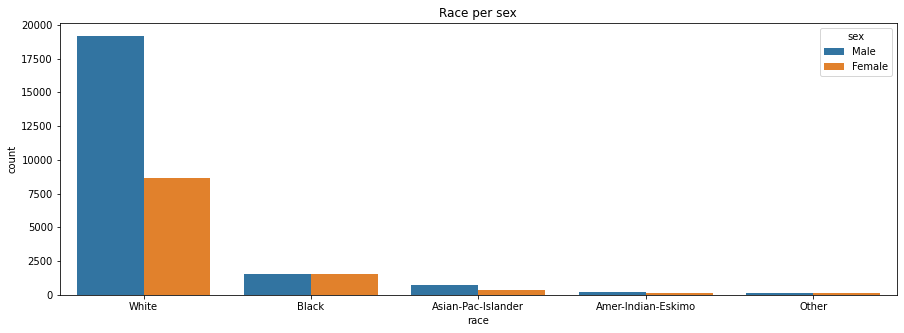

In [29]:
#race per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'race', hue = 'sex', data = train_adult)
plt.title('Race per sex')

Text(0.5, 1.0, 'Relationship per sex')

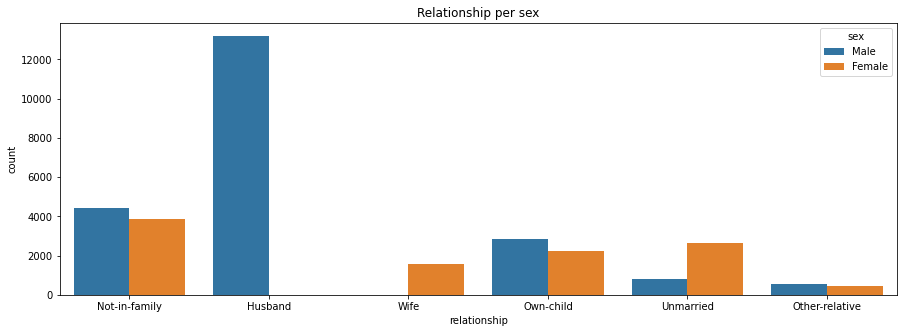

In [30]:
#relationship per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'relationship', hue = 'sex', data = train_adult)
plt.title('Relationship per sex')

Text(0.5, 1.0, 'Marital-status per sex')

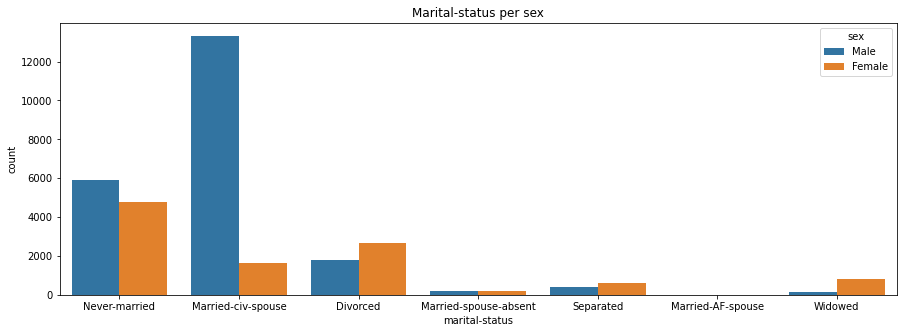

In [31]:
#marital-status per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'marital-status', hue = 'sex', data = train_adult)
plt.title('Marital-status per sex')

Text(0.5, 1.0, 'Marital-status per sex')

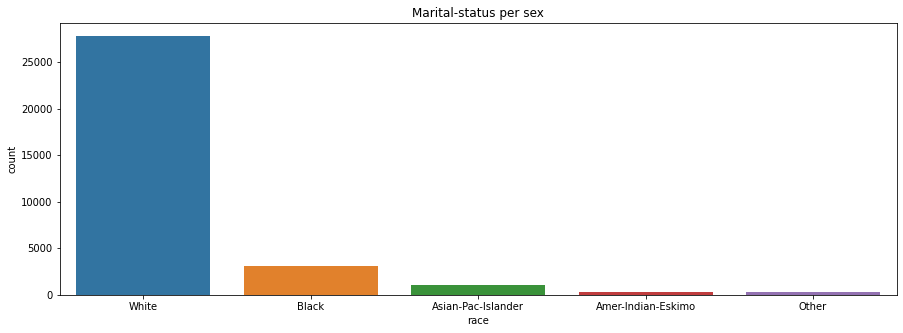

In [32]:
plt.figure(figsize=(15, 5))
sns.countplot(x = 'race',  data = train_adult)
plt.title('Marital-status per sex')

In [33]:
test_adult['relationship'].value_counts()

Husband           6523
Not-in-family     4278
Own-child         2513
Unmarried         1679
Wife               763
Other-relative     525
Name: relationship, dtype: int64

Text(0.5, 1.0, 'Income Frequency')

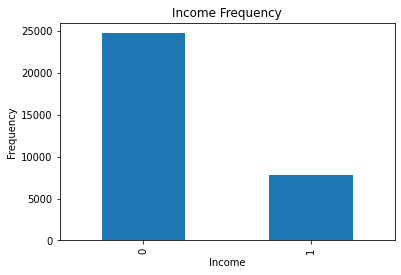

In [34]:
#visualising income 
train_adult['income'].value_counts().plot(kind='bar')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Frequency')

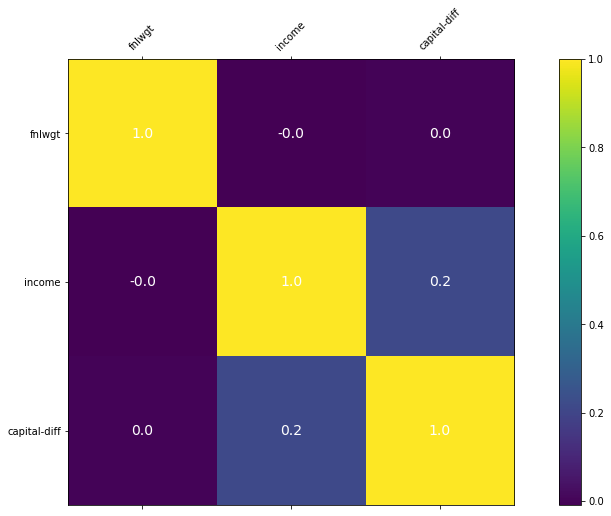

In [35]:
#get correlation between all discrete and continuous attributes 
plt.figure(figsize=(16,8))
plt.matshow(train_adult.corr(), fignum=1)
# plt.matshow(train_adult.corr())
plt.colorbar()
plt.xticks(np.arange(len(train_adult.corr().columns)), train_adult.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(train_adult.corr().columns)), train_adult.corr().columns.values) 
for (i, j), corr in np.ndenumerate(train_adult.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)


The above correlation visualisation showcases each of the attributes and their relationships with one another. Each non-categorical attribute is compared with each other, calculating their correlation coefficent. A positive value indicates the two variables move in the same direction and may be related, a negative value indicates the opposite. From the visualisation we can note that the attribute 'fnlwgt' has a correlation of 0 or -0.1 for each variable, thus indicating that it has no relationship with any other variables - this means we can drop this attribute altogether. For the desired attribute, income, one can note the positive correlation it has with the remainder of the attributes, having the strongest correlation with the education-num variable. In later sections we will dive more into these relationships and correlations within the dataset.

In [36]:
#fnlwgt attribute has no correlation with any other attributes, drop from dataset
train_adult.drop(['fnlwgt'], axis = 1, inplace = True)
test_adult.drop(['fnlwgt'], axis = 1, inplace = True)


In [37]:
train_adult.head()

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,31-40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Normal Working Week,United-States,0,2174
1,41-50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,Lesser Working Week,United-States,0,0
2,31-40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,Normal Working Week,United-States,0,0
3,51-60,Private,Secondary School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,Normal Working Week,United-States,0,0
4,21-30,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Normal Working Week,Other,0,0


Text(0.5, 1.0, 'Age per Sex')

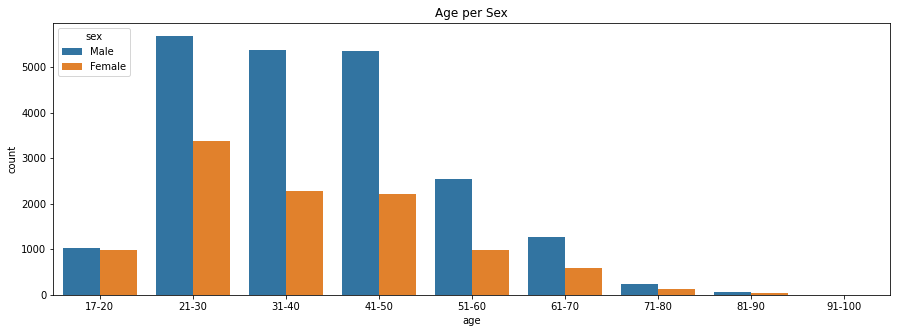

In [38]:
#age per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'age', hue = 'sex', data = train_adult)
plt.title('Age per Sex')


Text(0.5, 1.0, 'Hours-per-week per Sex')

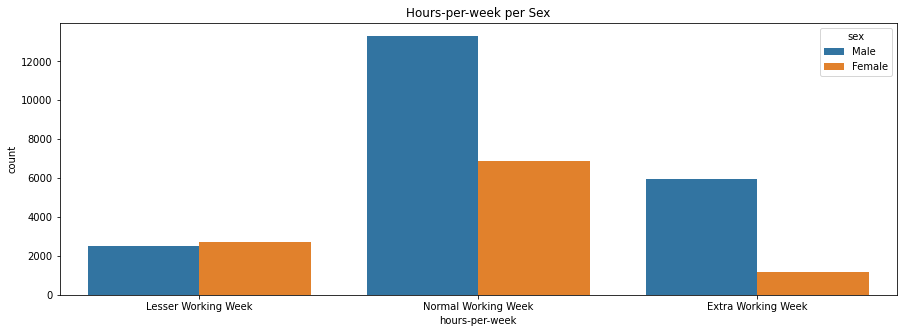

In [39]:
#hours-per-week per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'hours-per-week', hue = 'sex', data = train_adult)
plt.title('Hours-per-week per Sex')


Text(0.5, 1.0, 'Type of working week per age group')

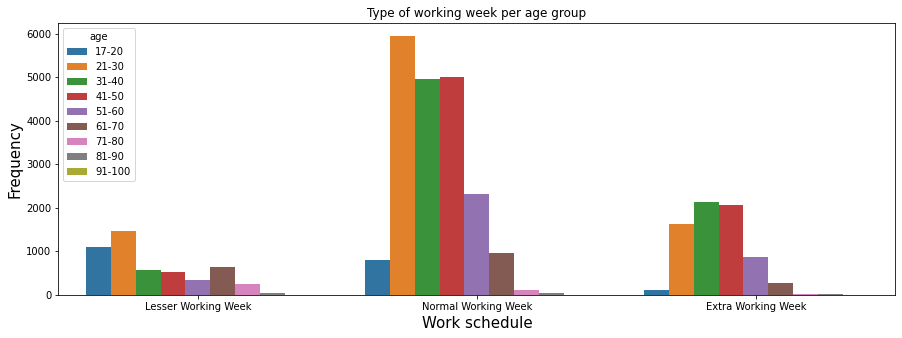

In [40]:
#Visualising working week vs age
plt.figure(figsize=(15, 5))
sns.countplot(x = 'hours-per-week', hue = 'age', data = train_adult)
plt.xlabel('Work schedule', fontsize =15)
plt.ylabel('Frequency', fontsize =15)
plt.title('Type of working week per age group')

**Analysing Income vs other non-sensitive attributes:**





(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Adm-clerical'),
  Text(1, 0, 'Exec-managerial'),
  Text(2, 0, 'Handlers-cleaners'),
  Text(3, 0, 'Prof-specialty'),
  Text(4, 0, 'Other-service'),
  Text(5, 0, 'Sales'),
  Text(6, 0, 'Craft-repair'),
  Text(7, 0, 'Transport-moving'),
  Text(8, 0, 'Farming-fishing'),
  Text(9, 0, 'Machine-op-inspct'),
  Text(10, 0, 'Tech-support'),
  Text(11, 0, 'Protective-serv'),
  Text(12, 0, 'Armed-Forces'),
  Text(13, 0, 'Priv-house-serv')])

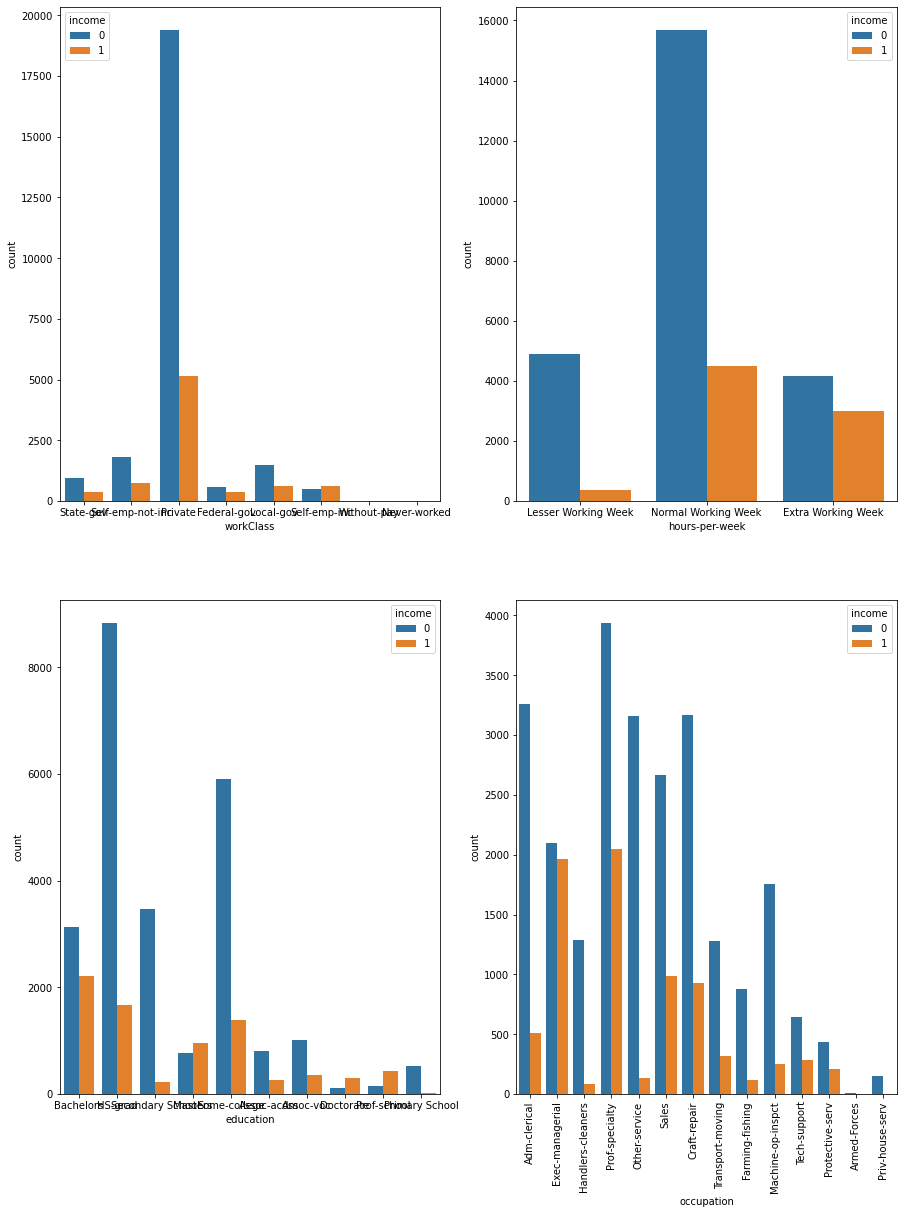

In [41]:
# dataset=train_adult.copy()
train_adult.head()

fig, ((a,b),(c,d)) = plt.subplots(2,2,figsize=(15,20))
sns.countplot(train_adult['workClass'],hue=train_adult['income'],ax=a)
plt.xticks(rotation=90)
sns.countplot(train_adult['hours-per-week'],hue=train_adult['income'],ax=b)
plt.xticks(rotation=90)
sns.countplot(train_adult['education'],hue=train_adult['income'],ax=c)
sns.countplot(train_adult['occupation'],hue=train_adult['income'],ax=d)
plt.xticks(rotation=90)


**Analysing Sensitive Attributes:** 
In the previous section, the dataset and its constiuent attributes were explored through summary statistics and visualisations. Through these visualisations it became apparent that many of the attributes are unequal and unfairly distributed in some cases. Some of this can be attributed to the general makeup of the dataset and the uneven distribution of some of the attributes but one may also conclude that there exists an element of individual or group unfairness. In this section I wil be analysing some of the more sensitive attributes in the adult dataset. These will include race, gender, marital status, age, native country and relatioship. The attributes will be compared against the target income variable, which should help in visualising and identifying any biases or unfairness that may be present as to whether an individual may have an income of >50,000.


In [42]:
# fig, ((a,b),(c,d)) = plt.subplots(2,2,figsize=(15,20))
# sns.countplot(train_adult['workClass'],hue=train_adult['income'],ax=a)
# plt.xticks(rotation=90)
# sns.countplot(train_adult['hours-per-week'],hue=train_adult['income'],ax=b)
# plt.xticks(rotation=90)
# sns.countplot(train_adult['education'],hue=train_adult['income'],ax=c)
# sns.countplot(train_adult['occupation'],hue=train_adult['income'],ax=d)
# plt.xticks(rotation=90)

Text(0.5, 1.0, 'Race vs Income')

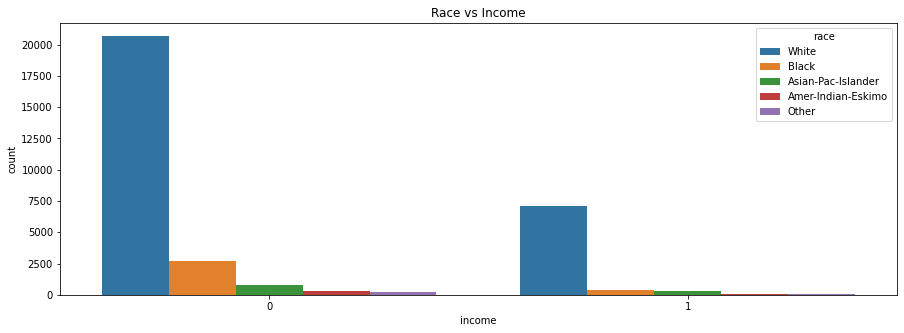

In [43]:
#Visualising income vs race
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'race', data = train_adult)
plt.title('Race vs Income')


Text(0.5, 1.0, 'Age vs Income')

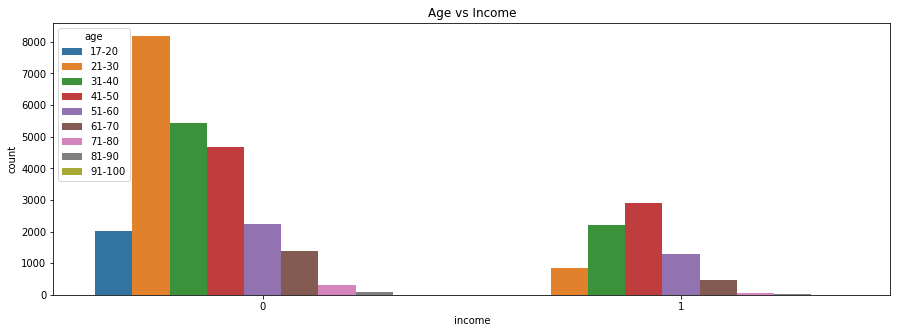

In [44]:
#visualising income vs age 
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income',hue = 'age', data = train_adult)
plt.title('Age vs Income')


Text(0.5, 1.0, 'Sex vs Income')

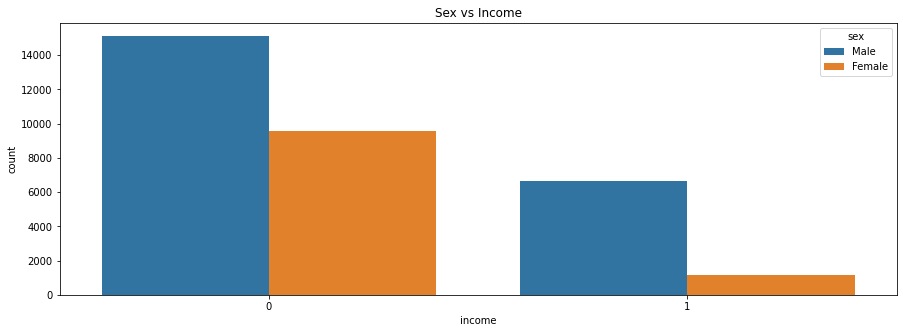

In [45]:
#visualising income vs sex
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'sex', data = train_adult)
plt.title('Sex vs Income')


Text(0.5, 1.0, 'Martial Status vs Income')

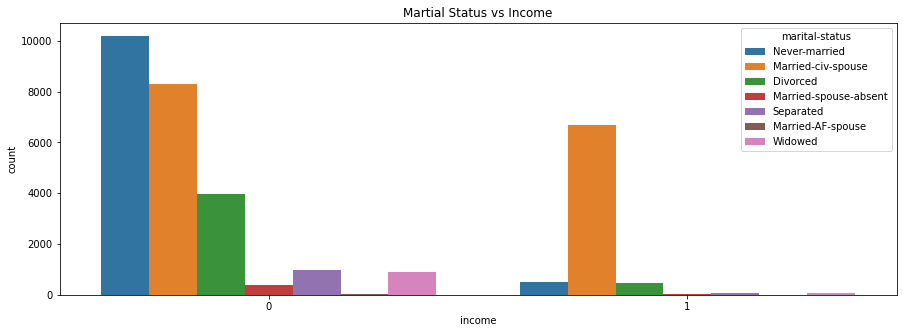

In [46]:
#visualising income vs marital status
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'marital-status', data = train_adult)
plt.title('Martial Status vs Income')


Text(0.5, 1.0, 'Relationship vs Income')

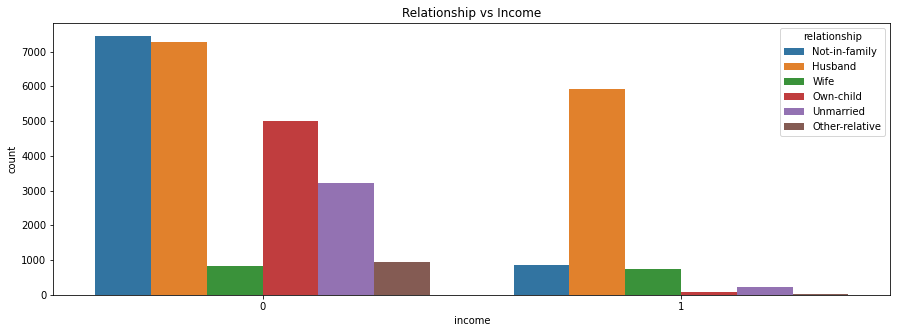

In [47]:
#visualising income vs relationship
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'relationship', data = train_adult)
plt.title('Relationship vs Income')


<AxesSubplot:xlabel='income', ylabel='count'>

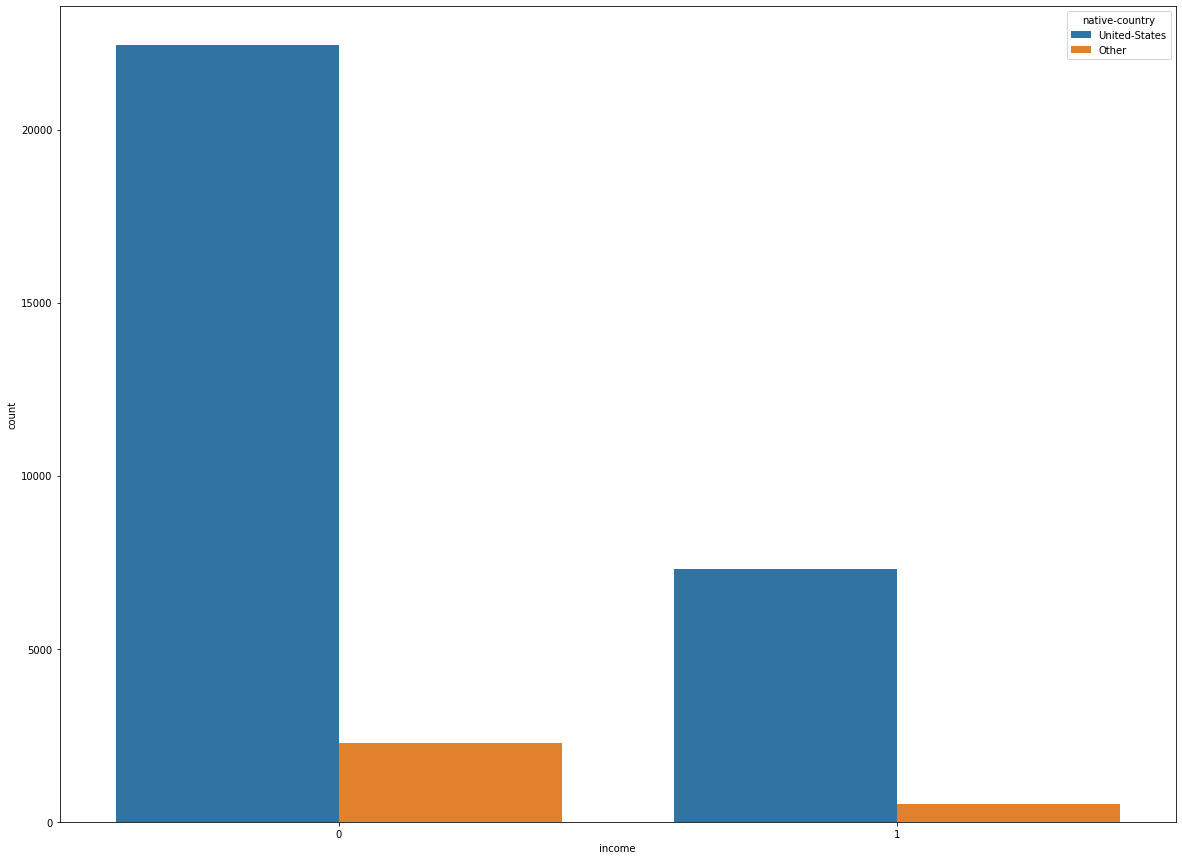

In [48]:
#visualising income vs native-country
plt.figure(figsize=(20, 15))
sns.countplot(x = 'income', hue = 'native-country', data = train_adult)   


<AxesSubplot:xlabel='income', ylabel='count'>

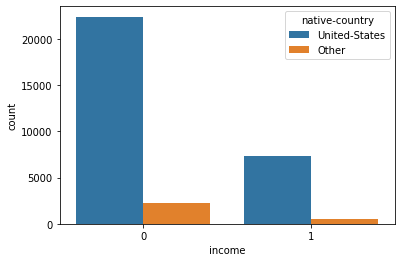

In [49]:
#visualising native-country vs income after transforming column
sns.countplot(x = 'income', hue = 'native-country', data = train_adult)  


In [50]:
train_adult.head()

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,31-40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Normal Working Week,United-States,0,2174
1,41-50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,Lesser Working Week,United-States,0,0
2,31-40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,Normal Working Week,United-States,0,0
3,51-60,Private,Secondary School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,Normal Working Week,United-States,0,0
4,21-30,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Normal Working Week,Other,0,0


## **Part 3: Building a classifer**
The aim of this section is to determine the most appropriate and accurate classification algorithm for the task of classifying if an individual will earn >50,000 per annum. All of the training features discussed thus far wil be used for training, with the income attribute being the target variable. A selection of classification algorithms are implemented and evaluated as well as a vigourous process of hyperparameter tuning to find the optimal set of hyperparameters for each classifier. The algorithms explored include: Random Forest, Decision Trees, Bagged Decision Trees, Logistic Regression, KNN, SVM, Stochastic Gradient Boosting, GausianNB and Convolutional Neural Networks. Note: All hyperparameter tuning code has been commented out.

###**Part 3.1: Splitting, encoding and scaling dataset**

In [51]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


In [52]:
#make copy of original training and test datasets 
train_data = train_adult.copy()
test_data = test_adult.copy()

train_test = train_adult.copy()

In [53]:
test_data

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,21-30,Private,Secondary School,Never-married,Machine-op-inspct,Own-child,Black,Male,Normal Working Week,United-States,0,0
1,31-40,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,Extra Working Week,United-States,0,0
2,21-30,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,Normal Working Week,United-States,1,0
3,41-50,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,Normal Working Week,United-States,1,7688
4,17-20,Private,Some-college,Never-married,Prof-specialty,Own-child,White,Female,Lesser Working Week,United-States,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,31-40,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,Normal Working Week,United-States,0,0
16277,61-70,Private,HS-grad,Widowed,Prof-specialty,Other-relative,Black,Male,Normal Working Week,United-States,0,0
16278,31-40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,Extra Working Week,United-States,0,0
16279,41-50,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,Normal Working Week,United-States,0,5455


In [54]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             16081 non-null  category
 1   workClass       16281 non-null  object  
 2   education       16281 non-null  object  
 3   marital-status  16281 non-null  object  
 4   occupation      16281 non-null  object  
 5   relationship    16281 non-null  object  
 6   race            16281 non-null  object  
 7   sex             16281 non-null  object  
 8   hours-per-week  16281 non-null  category
 9   native-country  16281 non-null  object  
 10  income          16281 non-null  int64   
 11  capital-diff    16281 non-null  int64   
dtypes: category(2), int64(2), object(8)
memory usage: 1.3+ MB


In [56]:
#encoding any object or category column dtypes as integers 
le = preprocessing.LabelEncoder()
train_data = train_data.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
test_data = test_data.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')


In [57]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             16281 non-null  int64
 1   workClass       16281 non-null  int64
 2   education       16281 non-null  int64
 3   marital-status  16281 non-null  int64
 4   occupation      16281 non-null  int64
 5   relationship    16281 non-null  int64
 6   race            16281 non-null  int64
 7   sex             16281 non-null  int64
 8   hours-per-week  16281 non-null  int64
 9   native-country  16281 non-null  int64
 10  income          16281 non-null  int64
 11  capital-diff    16281 non-null  int64
dtypes: int64(12)
memory usage: 1.5 MB


In [58]:
#splitting data into features and target 
X = train_data.drop(['income'], axis = 1)
Y = train_data['income']

In [59]:
X.head()  

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-diff
0,2,6,2,4,0,1,4,1,2,1,29
1,3,5,2,2,7,0,4,1,1,1,201
2,2,3,4,0,9,1,4,1,2,1,201
3,4,3,8,2,9,0,2,1,2,1,201
4,1,3,2,2,13,5,2,0,2,0,201


In [60]:
Y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int64

**Possibly sclaing and encoding and scaling multiple times????**

In [61]:
X_train = X 
Y_train = Y
X_test = test_data.drop(['income'],axis =1 )
Y_test = test_data['income']

In [62]:
Y_test.value_counts()

0    12435
1     3846
Name: income, dtype: int64

In [63]:
# #encode categorical variables in such that they contain only values between 0 and n_classes-1 and can then be used within the classifiers
# categorical = ['age','workClass','education', 'marital-status', 'occupation', 'relationship','race', 'sex','native-country']

# for feature in categorical:
#         le = preprocessing.LabelEncoder()
#         print(feature)
#         X_train[feature] = le.fit_transform(X_train[feature])
#         X_test[feature] = le.transform(X_test[feature])

In [64]:
#Standardize features in training and test sets by removing the mean and scaling to unit variance

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [65]:
X_train.head()


,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-diff
0,-0.234004,2.624298,-1.098810,0.921634,-1.705207,-0.277805,0.393668,0.703071,0.727859,0.307208,-4.054451
1,0.428725,1.721100,-1.098810,-0.406212,-0.038014,-0.900181,0.393668,0.703071,-0.486084,0.307208,0.338827
2,-0.234004,-0.085296,-0.393115,-1.734058,0.438327,-0.277805,0.393668,0.703071,0.727859,0.307208,0.338827
3,1.091454,-0.085296,1.018273,-0.406212,0.438327,-0.900181,-1.962621,0.703071,0.727859,0.307208,0.338827
4,-0.896732,-0.085296,-1.098810,-0.406212,1.391009,2.211698,-1.962621,-1.422331,0.727859,-3.255119,0.338827


In [66]:
X_test.head()

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-diff
0,-0.896732,-0.085296,1.018273,0.921634,0.676497,0.966947,-1.962621,0.703071,0.727859,0.307208,-0.350816
1,-0.234004,-0.085296,-0.393115,-0.406212,0.200156,-0.900181,0.393668,0.703071,-1.700028,0.307208,-0.350816
2,-0.896732,-1.891692,-1.804504,-0.406212,-1.228866,-0.900181,0.393668,0.703071,0.727859,0.307208,-0.350816
3,0.428725,-0.085296,1.371120,-0.406212,0.676497,-0.900181,-1.962621,0.703071,0.727859,0.307208,-2.343116
4,-1.559461,-0.085296,1.371120,0.921634,1.391009,0.966947,0.393668,-1.422331,-0.486084,0.307208,-0.350816


### **Part 3.2: Evaluating Classifiers**
Evaluating most of the available and popular classification algorithms on the dataset, using their default parameters. 
To DO: Ensure classifier accuracies have correct num of D.P

In [67]:
classifier_acc_train = {} 
classifier_acc_test = {} 
classifier_recall = {}
classifier_precision = {}
classifier_auc = {}
classifier_fprate = {}

In [69]:
#function for calculating the classifiers recall, precision, AUC and FP Rate
def eval_metrics(Y_test, Y_pred, classifier):
    
    print("Evaluation Metrics using {} classifier...\n".format(classifier))
    #getting confusion matrix, precision, recall and auc
    tn, fp, fn, tp  = confusion_matrix(Y_test, Y_pred).ravel()
    print("TN: {}\nFP: {}\nFN: {}\nTP: {}\n".format( tn, fp, fn, tp))
    recall = float(tp/(tp + fn))
    print("Recall: {}".format(recall))
    precision = tp/(tp + fp)
    print("Precision: {}".format(precision))
    fprate = fp / float(fp + tn)
    print("FP Rate: {}".format(fprate))
    auc = roc_auc_score(Y_test, Y_pred)
    print("ROC AUC: {}".format(auc))

    classifier_precision[classifier] = precision
    classifier_recall[classifier] = recall
    classifier_auc[classifier] = auc
    classifier_fprate[classifier] = fprate

##### **Part 3.2.1 Random Forest Classifier**

In [70]:
#Random Forest Classifer using default parameters 

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))

classifier_acc_train['RF'] = acc_random_forest
classifier_acc_test['RF'] = acc_random_forest_test


Accuracy of Random Forest Classifier on train data: 92.33%
Accuracy of Random Forest Classifier on test data: 77.93%


In [71]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 10321
FP: 2114
FN: 1480
TP: 2366

Recall: 0.6151846073842954
Precision: 0.528125
FP Rate: 0.17000402090872538
ROC AUC: 0.7225902932377851


#### **Part 3.2.2: Decision Tree Classifier** 

In [72]:
#Decision Tree Classifer using default parameters 

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print('Accuracy of Decision Tree Classifier on train data: {}%'.format(acc_decision_tree))
acc_decision_tree_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Decision Tree Classifier on test data: {}%'.format(round(acc_decision_tree_test*100,2)))

classifier_acc_train['Decision Tree'] = acc_decision_tree
classifier_acc_test['Decision Tree'] = acc_decision_tree_test

#get feature importance 

Accuracy of Decision Tree Classifier on train data: 92.33%
Accuracy of Decision Tree Classifier on test data: 37.7%


In [73]:
eval_metrics(Y_test, Y_pred, 'Decision Tree')

Evaluation Metrics using Decision Tree classifier...

TN: 4261
FP: 8174
FN: 1969
TP: 1877

Recall: 0.4880395215808632
Precision: 0.1867475873047458
FP Rate: 0.6573381584238038
ROC AUC: 0.4153506815785297


#### **Part 3.2.3: Bagged Decision Tree Classifier** 

In [74]:
#Bagged Decision Tree Classifer using default parameters 

bagged_decision_tree = BaggingClassifier()
bagged_decision_tree.fit(X_train, Y_train)
Y_pred = bagged_decision_tree.predict(X_test)
acc_bagged_decision_tree = round(bagged_decision_tree.score(X_train, Y_train) * 100, 2)
print('Accuracy of Bagged Decision Tree Classifier on train data: {}%'.format(acc_bagged_decision_tree))
acc_bagged_decision_tree_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Bagged Decision Tree Classifier on test data: {}%'.format(round(acc_bagged_decision_tree_test*100,2)))

classifier_acc_train['Bagged Decision Tree'] = acc_bagged_decision_tree
classifier_acc_test['Bagged Decision Tree'] = acc_bagged_decision_tree_test

Accuracy of Bagged Decision Tree Classifier on train data: 91.9%
Accuracy of Bagged Decision Tree Classifier on test data: 43.99%


In [75]:
eval_metrics(Y_test, Y_pred, 'Bagged Decision Tree')

Evaluation Metrics using Bagged Decision Tree classifier...

TN: 5153
FP: 7282
FN: 1837
TP: 2009

Recall: 0.5223608944357774
Precision: 0.2162307609514584
FP Rate: 0.5856051467631684
ROC AUC: 0.46837787383630447


#### **Part 3.2.4: Logistic Regression Classifier**  

In [76]:
#Logistic Regression Classifer using default parameters 
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_score = accuracy_score(Y_test, Y_pred)
print('Accuracy of Logistic Regression Classifier on train data: {0:0.2f}%' .format(acc_log))
acc_log_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Logistic Regression Classifier on test data: {}%'.format(round(acc_log_test*100,2)))

classifier_acc_train['Log Regression'] = acc_log
classifier_acc_test['Log Regression'] = acc_log_test

Accuracy of Logistic Regression Classifier on train data: 78.20%
Accuracy of Logistic Regression Classifier on test data: 78.15%


In [77]:
eval_metrics(Y_test, Y_pred, 'Log Regression')

Evaluation Metrics using Log Regression classifier...

TN: 11346
FP: 1089
FN: 2468
TP: 1378

Recall: 0.3582943317732709
Precision: 0.558573165788407
FP Rate: 0.08757539203860072
ROC AUC: 0.635359469867335


#### **Part 3.2.5: Logistic Regression with PCA Classifier** 
Get explained variance of each feature in dataset.

Text(0.5, 1.0, 'Variance explained by each feature in training data')

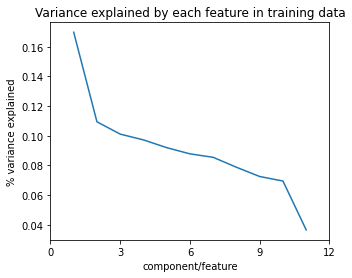

In [78]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_

plt.figure(figsize=(5,4))
plt.plot(range(1,12),pca.explained_variance_ratio_)
plt.xlim((0,12))
plt.xlabel("component/feature")
plt.xticks((0,3,6,9,12))
plt.ylabel("% variance explained")
plt.title('Variance explained by each feature in training data')

In [ ]:
#LDA??

#### **Part 3.2.6: KNN** 

In [79]:
#KNN Classifer using default parameters 
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train) 
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print('Accuracy of KNN Classifier on train data: {0:0.2f}%'.format(acc_knn))
acc_knn_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of KNN Classifier on test data: {}%'.format(round(acc_knn_test*100,2)))

classifier_acc_train['KNN'] = acc_knn
classifier_acc_test['KNN'] = acc_knn_test

Accuracy of KNN Classifier on train data: 85.97%
Accuracy of KNN Classifier on test data: 81.54%


In [80]:
eval_metrics(Y_test, Y_pred, 'KNN')

Evaluation Metrics using KNN classifier...

TN: 11144
FP: 1291
FN: 1714
TP: 2132

Recall: 0.5543421736869475
Precision: 0.6228454572012854
FP Rate: 0.10381986328910334
ROC AUC: 0.7252611551989222


#### **Part 3.2.7: SVM Classifier**   

In [81]:
#SVM Classifer using default parameters 

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print('Accuracy of SVM Classifier on train data: {0:0.2f}%'.format(acc_linear_svc))
acc_linear_svc_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of SVM Classifier on test data: {}%'.format(round(acc_linear_svc_test*100,2)))

classifier_acc_train['SVM'] = acc_linear_svc
classifier_acc_test['SVM'] = acc_linear_svc_test

Accuracy of SVM Classifier on train data: 78.05%
Accuracy of SVM Classifier on test data: 78.46%


In [82]:
eval_metrics(Y_test, Y_pred, 'SVM')

Evaluation Metrics using SVM classifier...

TN: 11672
FP: 763
FN: 2744
TP: 1102

Recall: 0.28653146125845036
Precision: 0.5908847184986595
FP Rate: 0.06135906714917572
ROC AUC: 0.6125861970546373


#### **Part 3.2.8: Stochastic Gradient Boosting Classifier**   

In [83]:
#Stochastic Gradient Boosting Classifier using default parameters 
model = GradientBoostingClassifier()
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, Y_train)
Y_pred = gradient_boost.predict(X_test)
acc_grad_boost = round(gradient_boost.score(X_train, Y_train) * 100, 2)
print('Accuracy of SGB Classifier on train data: {0:0.2f}%'.format(acc_grad_boost))
acc_grad_boost_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of SGB Classifier on test data: {}%'.format(round(acc_grad_boost_test*100,2)))

classifier_acc_train['SGB'] = acc_grad_boost
classifier_acc_test['SGB'] = acc_grad_boost_test


Accuracy of SGB Classifier on train data: 86.06%
Accuracy of SGB Classifier on test data: 79.79%


In [84]:
eval_metrics(Y_test, Y_pred, 'SGB')

Evaluation Metrics using SGB classifier...

TN: 10197
FP: 2238
FN: 1052
TP: 2794

Recall: 0.7264690587623505
Precision: 0.5552464228934817
FP Rate: 0.17997587454764777
ROC AUC: 0.7732465921073514


#### **Part 3.2.9: GaussianNB Classifier**    

In [85]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print('Accuracy of GNB Classifier on train data: {0:0.2f}%'.format(acc_gaussian))
acc_gaussian_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of GNB Classifier on test data: {}%'.format(round(acc_gaussian_test*100,2)))

classifier_acc_train['GNB'] = acc_gaussian
classifier_acc_test['GNB'] = acc_gaussian_test


Accuracy of GNB Classifier on train data: 76.80%
Accuracy of GNB Classifier on test data: 75.81%


In [86]:
eval_metrics(Y_test, Y_pred, 'GNB')

Evaluation Metrics using GNB classifier...

TN: 9683
FP: 2752
FN: 1186
TP: 2660

Recall: 0.6916276651066042
Precision: 0.49150036954915005
FP Rate: 0.22131081624447124
ROC AUC: 0.7351584244310665


#### **Part 3.2.10: CatBoost Classifier**  

In [87]:
clf= CatBoostClassifier(verbose=False)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
acc_catboost = round(clf.score(X_train, Y_train)*100,2)
print('Accuracy of CatBoost Classifier on train data: {0:0.2f}%'.format(acc_catboost))
acc_catboost_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of CatBoost Classifier on test data: {}%'.format(round(acc_catboost_test*100,2)))

classifier_acc_train['Cat'] = acc_catboost
classifier_acc_test['Cat'] = acc_catboost_test

Accuracy of CatBoost Classifier on train data: 88.70%
Accuracy of CatBoost Classifier on test data: 60.98%


In [88]:
eval_metrics(Y_test, Y_pred, 'Cat')

Evaluation Metrics using Cat classifier...

TN: 6771
FP: 5664
FN: 689
TP: 3157

Recall: 0.8208528341133645
Precision: 0.3578959301666478
FP Rate: 0.4554885404101327
ROC AUC: 0.6826821468516159


#### **Part 3.2.11: CNN Classifier** 

### **Part 3.3: Classifier Results** 

**Classifier Results from default parameters**

In [89]:
classifier_acc_train

{'Bagged Decision Tree': 91.9,
 'Cat': 88.7,
 'Decision Tree': 92.33,
 'GNB': 76.8,
 'KNN': 85.97,
 'Log Regression': 78.2,
 'RF': 92.33,
 'SGB': 86.06,
 'SVM': 78.05}

In [90]:
classifier_acc_test.update((x, y*100) for x, y in classifier_acc_test.items())


In [91]:
classifier_acc_test

{'Bagged Decision Tree': 43.98992690866655,
 'Cat': 60.97905534058105,
 'Decision Tree': 37.7003869541183,
 'GNB': 75.81229654198145,
 'KNN': 81.54290277010011,
 'Log Regression': 78.15244763835145,
 'RF': 77.9251888704625,
 'SGB': 79.79239604446902,
 'SVM': 78.45955408144462}

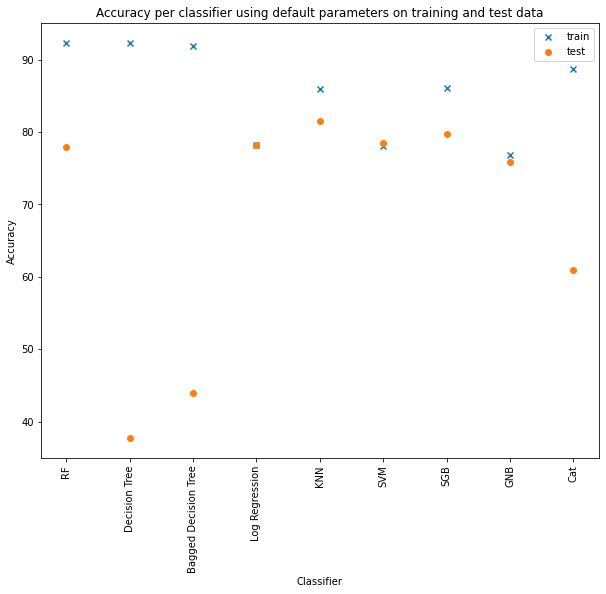

In [92]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_acc_train.keys(), classifier_acc_train.values(),  marker='x', label='train')
plt.scatter(classifier_acc_test.keys(), classifier_acc_test.values(),  marker='o',label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Accuracy per classifier using default parameters on training and test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()


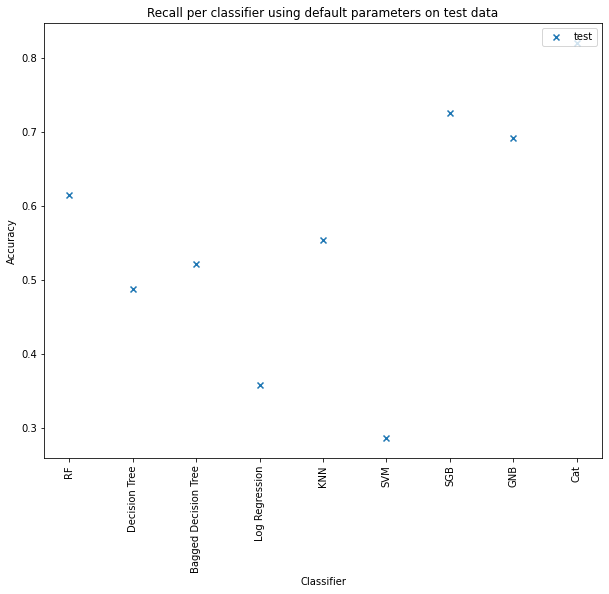

In [93]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_recall.keys(), classifier_recall.values(),  marker='x', label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Recall per classifier using default parameters on test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()


In [94]:
classifier_precision

{'Bagged Decision Tree': 0.2162307609514584,
 'Cat': 0.3578959301666478,
 'Decision Tree': 0.1867475873047458,
 'GNB': 0.49150036954915005,
 'KNN': 0.6228454572012854,
 'Log Regression': 0.558573165788407,
 'RF': 0.528125,
 'SGB': 0.5552464228934817,
 'SVM': 0.5908847184986595}

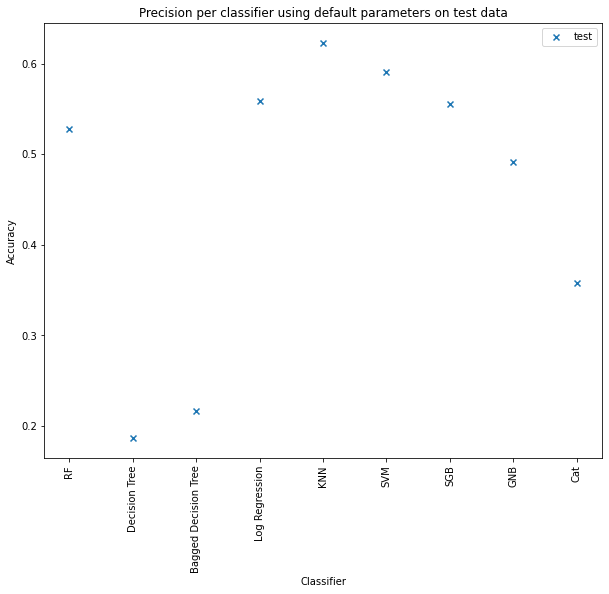

In [95]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_precision.keys(), classifier_precision.values(),  marker='x', label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Precision per classifier using default parameters on test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()

In [96]:
classifier_auc

{'Bagged Decision Tree': 0.46837787383630447,
 'Cat': 0.6826821468516159,
 'Decision Tree': 0.4153506815785297,
 'GNB': 0.7351584244310665,
 'KNN': 0.7252611551989222,
 'Log Regression': 0.635359469867335,
 'RF': 0.7225902932377851,
 'SGB': 0.7732465921073514,
 'SVM': 0.6125861970546373}

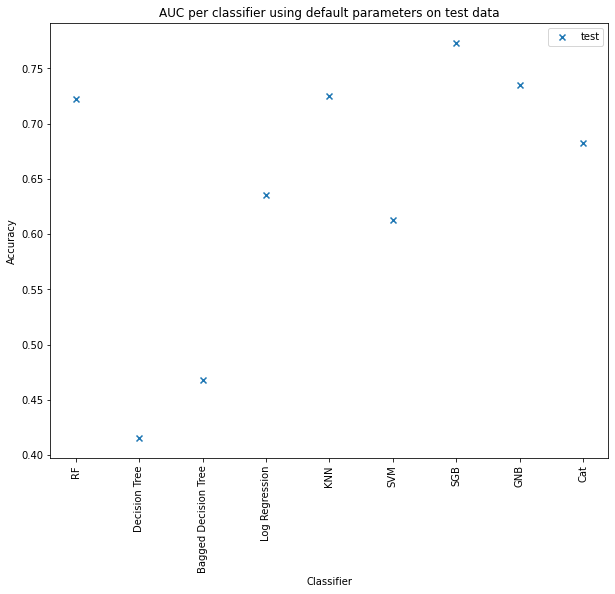

In [97]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_auc.keys(), classifier_auc.values(),  marker='x', label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('AUC per classifier using default parameters on test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()

###**Part 3.4 - Hyperparameter Tuning** <br>

*hyperparameter tuning function skipped in this section to avoid long hyperparamter tuning process

In [98]:
classifier_hptuning_scores = {}
classifier_hptuning_params = {}
classifier_hptuning_recall = {}
classifier_hptuning_precision = {}
classifier_hptuning_auc = {}


In [99]:

def tune_classifier(classifier, model, grid, training, labels):

    print('Hyperparameter Tuning for {} classifer...'.format(classifier))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(training, labels)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print('\n')
    classifier_hptuning_scores[classifier] = grid_result.best_score_
    classifier_hptuning_params[classifier] = grid_result.best_params_

#for all models/classifiers call 
# tune_classifer(model, grid)

In [100]:
#tune all classifiers 

grid_classifiers = {}

#Random Forest Classifer
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
grid_rf = dict(n_estimators=n_estimators,max_features=max_features)
grid_classifiers['RF'] = grid_rf

#Decision Tree Classifier
criterion = ['gini','entropy']
max_depth = range(1,10)
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)
grid_dt = dict(criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
grid_classifiers['DT'] = grid_dt

#Bagged Decision Tree Classifier
n_estimators = [10, 100, 1000]
grid_bdt = dict(n_estimators=n_estimators)
grid_classifiers['BDT'] = grid_bdt


#Logisitc Regression Classifier
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid_logreg = dict(solver=solvers,penalty=penalty,C=c_values)
grid_classifiers['Log'] = grid_logreg


#KNN Classifer
n_neighbours = np.arange(1,15,2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid_knn = dict(n_neighbors=n_neighbours,weights=weights,metric=metric)
grid_classifiers['KNN'] = grid_knn

#SVM Classifier
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
grid_svm = dict(kernel=kernel,C=C,gamma=gamma)
grid_classifiers['SVM'] = grid_svm

#Gradient Boosting Classifier
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
grid_gb = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
grid_classifiers['GB'] = grid_gb


#GaussianNB Classifier
var_smoothing = np.logspace(0,-9, num=100)
grid_gnb = dict(var_smoothing=var_smoothing)
grid_classifiers['GNB'] = grid_gnb

#CatBoost Classifier
depth = [3,1,2,6,4,5,7,8,9,10]
iterations = [250,100,500,1000]
learning_rate = [0.03,0.001,0.01,0.1,0.2,0.3]
l2_leaf_reg = [3,1,5,10,100]
border_count = [32,5,10,20,50,100,200]
ctr_border_count = [50,5,10,20,100,200]
thread_count = 4
grid_cat = dict(depth=depth, iterations=iterations, learning_rate=learning_rate, l2_leaf_reg=l2_leaf_reg,border_count=border_count,ctr_border_count=ctr_border_count,thread_count=thread_count)
grid_classifiers['Cat'] = grid_cat

In [101]:
grid_classifiers['GB']

{'learning_rate': [0.001, 0.01, 0.1],
 'max_depth': [3, 7, 9],
 'n_estimators': [10, 100, 1000],
 'subsample': [0.5, 0.7, 1.0]}

In [102]:
grid_classifiers['RF']

{'max_features': ['sqrt', 'log2'], 'n_estimators': [10, 100, 1000]}

In [103]:

################################################################
###        Hyperparameter Tuning for all Classifiers         ###
################################################################

def hyperparameter_tuning():

  for key in grid_classifiers:
    if key == 'RF':
      model = RandomForestClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'DT':
      model = DecisionTreeClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'BDT':
      model = BaggingClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'Log':
      model = LogisticRegression()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'KNN':
      model = KNeighborsClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'SVM':      #SVM takes a very long time to execute 
      model = SVC()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'GB':
      model = GradientBoostingClassifier()
      tune_classifier(key,model,grid_classifiers[key])
    elif key == 'GNB':
      model = GaussianNB()
      tune_classifier(key,model,grid_classifiers[key])
    elif key == 'Cat':
      model = CatBoostClassifier()
      tune_classifier(key,model,grid_classifiers[key])


In [107]:
### Below commented out due to its high computational complexity ###
#getting best hyperparameters for each classifier
# start_time = time.clock()
# hyperparameter_tuning()

# elapsed_time = time.clock() - start_time
# print('Total time for hyperparameter tuning: ', elapsed_time)


In [108]:
#get classificer metrics, accuracy, AUC, precision, recall, FP/FN etc

###**Part 3.5 - Selecting Classifier** <br>
After the above process of hyperparameter tuning, the choice of classifier for the bias analysis task is the **Random Forest** classifier. This algorithm gave accuracy results of ~85%. The chosen hyperparameters chosen for it are **n_estimators = 1000** and the **max_features = log2**, with all other parameters set to their default value. Although some classifiers gave a slightly increased classification accuracy such as SVM, they were not chosen due to the simplicity of RF's and the enhanced computational complexity and training time of other classifiers.

In [110]:
model = RandomForestClassifier()
tune_classifier('RF',model,grid_classifiers['RF'], X_train, Y_train)

In [ ]:
#training chosen classifier with desired parameters
random_forest = RandomForestClassifier(n_estimators=1000,max_features='sqrt')
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))

Accuracy of Random Forest Classifier on train data: 92.33%
Accuracy of Random Forest Classifier on test data: 82.77%


In [ ]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11412
FP: 1023
FN: 1783
TP: 2063

Recall: 0.5364014560582423
Precision: 0.66850291639663
FP Rate: 0.08226779252110977
ROC AUC: 0.7270668317685663


Text(0.5, 1.0, 'Feature Importance for each attribute using optimised classifier')

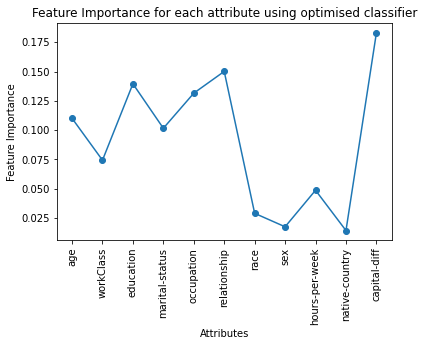

In [ ]:
plt.plot(random_forest.feature_importances_,  marker='o')
plt.xticks(np.arange(len(list(X_train.columns))), list(X_train.columns), rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for each attribute using optimised classifier')      #protecsted attributes still here???? 

## **Part 4: Identifying and evaluating bias**
After selecting a classifcation algorithm, as was achieved in the previous section, the next step is to identify and evaluate any bias that may be present in some of the protected attributes of the dataset, including: martial-status, relationship, race, sex and native-country. The chosen attributes for deeper analysis were relationship and race.

###**Part 4.1: Quantifying fairness and bias** 

In [111]:
#getting the index of each misclassification in prediction
def incorrect_classification(Y_test, Y_pred):

    incorrect_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] != Y_test[i]:
        incorrect_index.append(i)
    
    return incorrect_index

#getting the index of each positive classification in prediction
def positive_classification(Y_test, Y_pred):

    correct_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] == 1:
        correct_index.append(i)
        
    return correct_index

#getting the index of each negative classification in prediction
def negative_classification(Y_test, Y_pred):

    correct_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] == 0:
        correct_index.append(i)
        
    return correct_index

#getting the index of each correct classification in prediction
def correct_classification(Y_test, Y_pred):

    correct_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] == Y_test[i]:
        correct_index.append(i)
        
    return correct_index

#getting demographic parity in prediction for specified attribute
#demographic parity outlines that the positive rate should be the same across all demographic groups within the attribute 
#e.g the classifcation of >50k should have the same rate for white and black folks for race attribute 
def demographic_parity(Y_test, Y_pred, attribute):

    # correct_class = correct_classification(Y_test, Y_pred)
    correct_class = positive_classification(Y_test, Y_pred)
    class_labels = test_adult[attribute].unique()

    demo_parity = dict.fromkeys(class_labels, 0)
    total_correct = 0

    for i in correct_class:
      for j in class_labels:
        if (test_adult[attribute][i]) == j:
          demo_parity[j] = demo_parity[j] + 1
          total_correct += 1

    for key, val in demo_parity.items():
      total_for_label = test_adult[attribute].value_counts()[key]
      demo_par = demo_parity[key] / total_for_label
      demo_parity[key] = demo_par

    return demo_parity 

    # P(Ŷ | A = 0) = P(Ŷ | A = 1) = P(Ŷ | A = 2)...

    # pass

#getting equality of opportunity metric - TNR and or TPR should be the same for all classes in a group
def equality_of_opportunity(Y_test, Y_pred, attribute):

    class_labels = test_adult[attribute].unique()

    equal_opp = dict.fromkeys(class_labels, 0)

    for i in range(0, len(Y_pred)):
      if Y_pred[i] == 1:
        if test_adult['income'][i] == 1:
          attribute_class = test_adult[attribute][i]
          equal_opp[attribute_class] = equal_opp[attribute_class] + 1

    for key, val in equal_opp.items():
      total_for_label = test_adult[attribute].value_counts()[key]
      eq_op = equal_opp[key] / total_for_label
      equal_opp[key] = eq_op

    return equal_opp
      # True Positive Rate (A=0) = True Positive Rate (A=1)
  
#work out fp rate and combine with equal_of_opp
def equalised_odds(Y_test, Y_pred, attribute):

    demo_par = demographic_parity(Y_test, Y_pred, attribute)
    demo_par_vals = []
    for k, v in demo_par.items():
      demo_par_vals.append(demo_par[k])

    equal_op = equality_of_opportunity(Y_test, Y_pred, attribute)
    equal_op_vals = []
    for k, v in equal_op.items():
      equal_op_vals.append(equal_op[k])
    
    fp_rates = []

    for val in range(0, len(demo_par_vals)):
      fp_rates.append(demo_par_vals[val] - equal_op_vals[val])
    
        
    class_labels = test_adult[attribute].unique()

    equal_odds = dict.fromkeys(class_labels, 0)
    
    # fp_rate = demographic_parity() - equality_of_opportunity()
    
    # for i in range(0, len(Y_pred)):
    #   if Y_pred[i] == 1:
    #     if test_adult['income'][i] == 0:
    #       att = test_adult[attribute][i]
    #       equal_odds[att] = equal_odds[att] + 1

    #get true pos
    equal_of_opp = equality_of_opportunity(Y_test, Y_pred, attribute)

    i = 0 
    for k,v in equal_of_opp.items():
      equal_odds[k] = equal_of_opp[k] + fp_rates[i]
      i+=1

    for key, val in equal_odds.items():
      total_for_label = test_adult[attribute].value_counts()[key]
      equalised_odds = equal_odds[key] / total_for_label
      equal_odds[key] = equalised_odds

    return equal_odds   #returning TP rate & FP Rate 

def fairness_metrics(Y_test, Y_pred, attribute, verbose=False):

    demo_parity = demographic_parity(Y_test, Y_pred, attribute)
    eq_of_opp = equality_of_opportunity(Y_test, Y_pred, attribute)
    eq_odds = equalised_odds(Y_test, Y_pred, attribute)

    if verbose:
      print('Demographic parity for {} is {} '.format(attribute, demo_parity))
      print('Equality of opportunity for {} is {} '.format(attribute, eq_of_opp))
      print('Equalised Odds for {} is {} \n'.format(attribute, eq_odds))

    return demo_parity, eq_of_opp, eq_odds

#   True Positive Rate (A=0) = True Positive Rate (A=1) , and
# False Positive Rate (A=0) = False Positive Rate (A=1)

In [113]:
def pie_plot(attribute, Y_test, Y_pred, plot_type='correct', correct_class=True):

    class_labels = test_adult[attribute].unique()

    if plot_type == 'correct':
       index = correct_classification(Y_test, Y_pred)
    elif plot_type == 'incorrect':
       index = incorrect_classification(Y_test, Y_pred)
    elif plot_type == 'positive':
       index = positive_classification(Y_test, Y_pred)
    elif plot_type == 'negative':
       index = negative_classification(Y_test, Y_pred)

    classification_ratio = dict.fromkeys(class_labels, 0)

    for i in index:
      for j in class_labels:
        if (test_adult[attribute][i]) == j:
          classification_ratio[j] = classification_ratio[j] + 1

    # Pie chart
    labels = list(classification_ratio.keys())
    values = list(classification_ratio.values())
    #colors
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#9933FF','#FCFF33', '#E25626','#E4ABCA','#B9B9B9']
    #explsion
    explode = [0.05] * len(labels)
    # (0.05,0.05,0.05,0.05,0.05)

    plt.figure(figsize=(12,8))
    plt.pie(values, colors = colors,  autopct='%1.1f%%', startangle=90, explode=explode,pctdistance=0.85, rotatelabels=True, shadow=True)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    # ax1.axis('equal')  
    plt.tight_layout()
    plt.legend(labels)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
  
    if correct_class:
      plt.title('Pie plot of correct classification for {} attribute'.format(attribute))
    else:
      plt.title('Pie plot of incorrect classification for {} attribute'.format(attribute))

    plt.show()

def plotting_metrics(metric='demographic_parity'):

    # sensitive_attrs = ['marital-status', 'relationship','sex','race','native-country']
    sensitive_attrs = ['relationship','race']

    colors = ['red','green','blue','orange','purple']

    initial_subplot = 1
    initial_color = 0
    plt.figure(figsize=(16,8))

    for attr in sensitive_attrs:

        demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, attr)
        labels = test_adult[attr].unique()

        if metric =='demographic_parity':
          vals = list(demo_parity.values()) 
        elif metric =='equality_of_opportunity':
          vals = list(eq_of_opp.values()) 
        elif metric =='equalised_odds':
           vals = list(eq_odds.values()) 
        else: 
          print('Invalid metric passed to function')

        plt.subplot(2, 3, initial_subplot)
        plt.bar(labels,vals, color=colors[initial_color])
        plt.xticks(rotation=90)

        initial_subplot+=1
        initial_color+=1

    plt.tight_layout(pad=0.6)
    plt.show()

### **Part 4.2 Excluding all protected attributes from classification model** 

In [114]:
X_train_bias_all = X_train.copy()
X_test_bias_all = X_test.copy()

In [115]:
X_train_bias_all = X_train_bias_all.drop(['marital-status', 'relationship','race','sex','native-country'],axis =1)
X_test_bias_all = X_test_bias_all.drop(['marital-status', 'relationship','race','sex','native-country'], axis = 1)

In [116]:
X_train_bias_all.head()

,age,workClass,education,occupation,hours-per-week,capital-diff
0,-0.234004,2.624298,-1.098810,-1.705207,0.727859,-4.054451
1,0.428725,1.721100,-1.098810,-0.038014,-0.486084,0.338827
2,-0.234004,-0.085296,-0.393115,0.438327,0.727859,0.338827
3,1.091454,-0.085296,1.018273,0.438327,0.727859,0.338827
4,-0.896732,-0.085296,-1.098810,1.391009,0.727859,0.338827


In [118]:
# #hyperparameter tuning with all protected attributes removed
model = RandomForestClassifier()
tune_classifier('RF',model,grid_classifiers['RF'], X_train_bias_all, Y_train)  

In [ ]:
#training classifier using optimal parameters 
random_forest = RandomForestClassifier(n_estimators=1000, max_features='log2')  #check using optimal params
random_forest.fit(X_train_bias_all, Y_train)

Y_pred = random_forest.predict(X_test_bias_all)
random_forest.score(X_train_bias_all, Y_train)

acc_random_forest = round(random_forest.score(X_train_bias_all, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))

In [ ]:
eval_metrics(Y_test, Y_pred, 'RF')

####**Part 4.2.1: Plots and visualisations**

In [ ]:
plt.plot(random_forest.feature_importances_,  marker='o')
plt.xticks(np.arange(len(list(X_train_bias_all.columns))), list(X_train_bias_all.columns), rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for each attribute')     

In [ ]:
plotting_metrics(metric='demographic_parity')

In [ ]:
plotting_metrics(metric='equality_of_opportunity')

In [ ]:
# plotting_metrics(metric='equalised_odds')

In [ ]:
pie_plot('race', Y_test, Y_pred)

In [ ]:
pie_plot('sex', Y_test, Y_pred)

In [ ]:
pie_plot('relationship', Y_test, Y_pred)

In [ ]:
pie_plot('marital-status', Y_test, Y_pred)

In [ ]:
pie_plot('native-country', Y_test, Y_pred)

###**Part 4.3: Excluding relationship and race attributes from classification model** 

In [ ]:
X_train_bias = X_train.copy()
X_test_bias = X_test.copy()

In [ ]:
X_train_bias = X_train_bias.drop(['relationship','race'],axis =1)
X_test_bias = X_test_bias.drop(['relationship','race'], axis = 1)

In [ ]:
#hyperparameter tuning with two protected attributes removed
model = RandomForestClassifier()
tune_classifier('RF',model,grid_classifiers['RF'], X_train_bias, Y_train) #***

Hyperparameter Tuning for RF classifer...
Best: 0.850813 using {'max_features': 'log2', 'n_estimators': 1000}
0.845398 (0.004297) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.849094 (0.004962) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.850342 (0.004764) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.844589 (0.005638) with: {'max_features': 'log2', 'n_estimators': 10}
0.849288 (0.004832) with: {'max_features': 'log2', 'n_estimators': 100}
0.850813 (0.005275) with: {'max_features': 'log2', 'n_estimators': 1000}




In [ ]:
#training with optimal parameters 
random_forest = RandomForestClassifier(n_estimators=1000, max_features='log2')
random_forest.fit(X_train_bias, Y_train)

Y_pred = random_forest.predict(X_test_bias)
random_forest.score(X_train_bias, Y_train)

acc_random_forest = round(random_forest.score(X_train_bias, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))


Accuracy of Random Forest Classifier on train data: 91.47%
Accuracy of Random Forest Classifier on test data: 82.48%


In [ ]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11312
FP: 1123
FN: 1730
TP: 2116

Recall: 0.5501820072802912
Precision: 0.6532880518678604
FP Rate: 0.09030960997185364
ROC AUC: 0.7299361986542188


In [ ]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'race')

In [ ]:
demo_parity

{'Amer-Indian-Eskimo': 0.10062893081761007,
 'Asian-Pac-Islander': 0.25416666666666665,
 'Black': 0.10121716848174248,
 'Other': 0.07407407407407407,
 'White': 0.2103112003441847}

In [ ]:
print('Average demographic Pariy for race attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for race attribute is 0.14807960807685558


In [ ]:
eq_of_opp

{'Amer-Indian-Eskimo': 0.05660377358490566,
 'Asian-Pac-Islander': 0.15833333333333333,
 'Black': 0.05637411915438821,
 'Other': 0.05185185185185185,
 'White': 0.13882116735981642}

In [ ]:
print('Average Equality of opportunity for race attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for race attribute is 0.0923968490568591


In [ ]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'relationship')

In [ ]:
demo_parity

{'Husband': 0.3723746742296489,
 'Not-in-family': 0.08251519401589527,
 'Other-relative': 0.0419047619047619,
 'Own-child': 0.01830481496219658,
 'Unmarried': 0.05122096486003574,
 'Wife': 0.39711664482306686}

In [ ]:
#calculate average DP over all classes in attribute

In [ ]:
print('Average demographic Pariy for relationship attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for relationship attribute is 0.1605728424659342


In [ ]:
eq_of_opp

{'Husband': 0.2639889621339874,
 'Not-in-family': 0.03272557269752221,
 'Other-relative': 0.005714285714285714,
 'Own-child': 0.00477516912057302,
 'Unmarried': 0.016081000595592615,
 'Wife': 0.2778505897771953}

In [ ]:
print('Average Equality of opportunity for relationship attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for relationship attribute is 0.10018926333985935


**Evaluating metrics with different RF Hyperparameters**



In [ ]:
#training with optimal parameters 
random_forest = RandomForestClassifier(n_estimators=250, max_features='log2')
random_forest.fit(X_train_bias, Y_train)

Y_pred = random_forest.predict(X_test_bias)
random_forest.score(X_train_bias, Y_train)

acc_random_forest = round(random_forest.score(X_train_bias, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))

Accuracy of Random Forest Classifier on train data: 91.47%
Accuracy of Random Forest Classifier on test data: 82.34%


In [ ]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11293
FP: 1142
FN: 1733
TP: 2113

Recall: 0.5494019760790432
Precision: 0.6491551459293394
FP Rate: 0.09183755528749497
ROC AUC: 0.7287822103957742


In [ ]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'race')

In [ ]:
demo_parity

{'Amer-Indian-Eskimo': 0.08176100628930817,
 'Asian-Pac-Islander': 0.275,
 'Black': 0.10121716848174248,
 'Other': 0.07407407407407407,
 'White': 0.21095654668005162}

In [ ]:
print('Average demographic Pariy for race attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for race attribute is 0.14860175910503529


In [ ]:
eq_of_opp

{'Amer-Indian-Eskimo': 0.050314465408805034,
 'Asian-Pac-Islander': 0.16666666666666666,
 'Black': 0.05445227418321589,
 'Other': 0.05185185185185185,
 'White': 0.13860605191452746}

In [ ]:
print('Average Equality of opportunity for race attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for race attribute is 0.09237826200501338


In [ ]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'relationship')

In [ ]:
demo_parity

{'Husband': 0.37268128161888703,
 'Not-in-family': 0.08508648901355774,
 'Other-relative': 0.05142857142857143,
 'Own-child': 0.017906884202148827,
 'Unmarried': 0.04705181655747469,
 'Wife': 0.40498034076015726}

In [ ]:
#calculate average DP over all classes in attribute

In [ ]:
print('Average demographic Pariy for relationship attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for relationship attribute is 0.1631892305967995


In [ ]:
eq_of_opp

{'Husband': 0.2632224436608922,
 'Not-in-family': 0.03272557269752221,
 'Other-relative': 0.007619047619047619,
 'Own-child': 0.004377238360525269,
 'Unmarried': 0.01429422275163788,
 'Wife': 0.28440366972477066}

In [ ]:
print('Average Equality of opportunity for relationship attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for relationship attribute is 0.10110703246906598


####**Part 4.3.1: Plots and visualisations**

Text(0.5, 1.0, 'Feature Importance for each attribute')

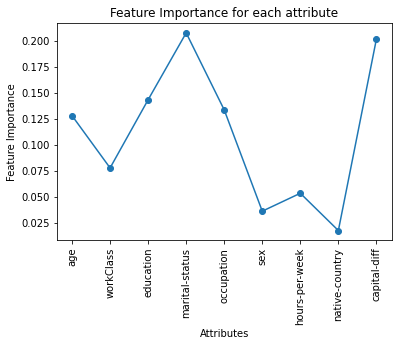

In [ ]:
plt.plot(random_forest.feature_importances_,  marker='o')
plt.xticks(np.arange(len(list(X_train_bias.columns))), list(X_train_bias.columns), rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for each attribute')      #protecsted attributes still here???? 

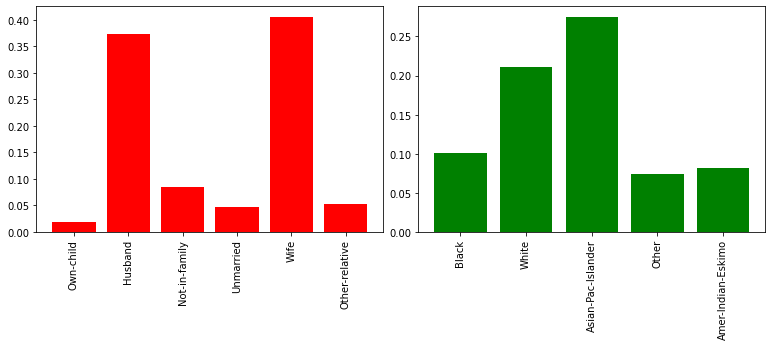

In [ ]:
plotting_metrics(metric='demographic_parity')

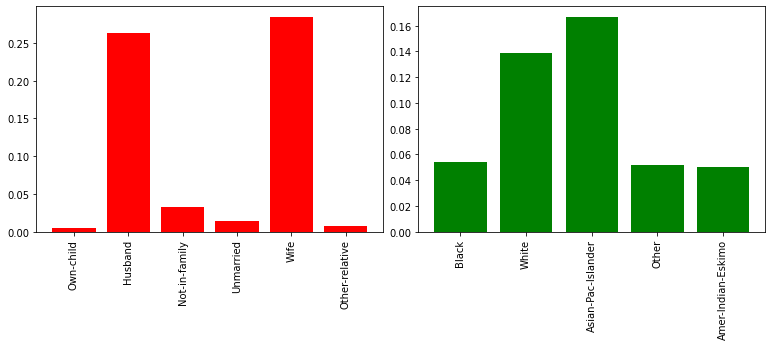

In [ ]:
plotting_metrics(metric='equality_of_opportunity')

In [ ]:
# plotting_metrics(metric='equalised_odds')

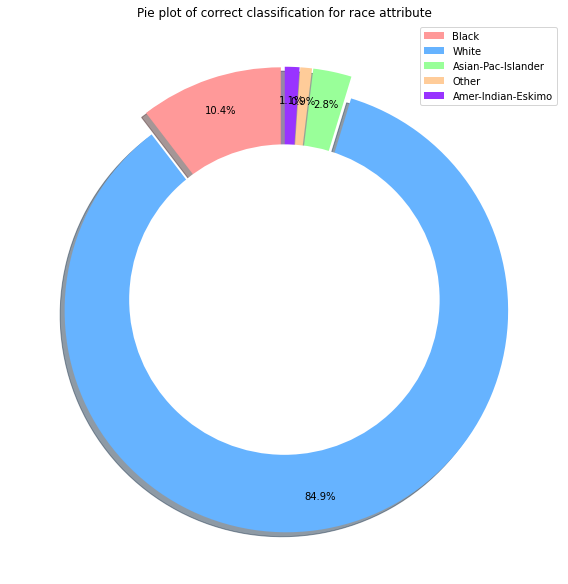

In [ ]:
pie_plot('race', Y_test, Y_pred)

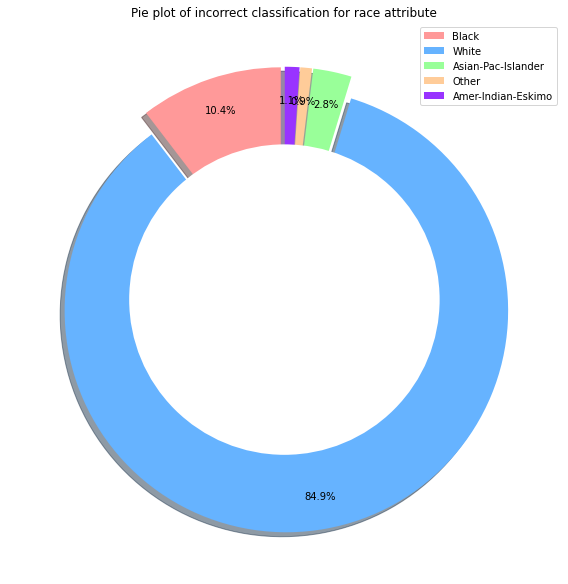

In [ ]:
pie_plot('race', Y_test, Y_pred, correct_class=False)

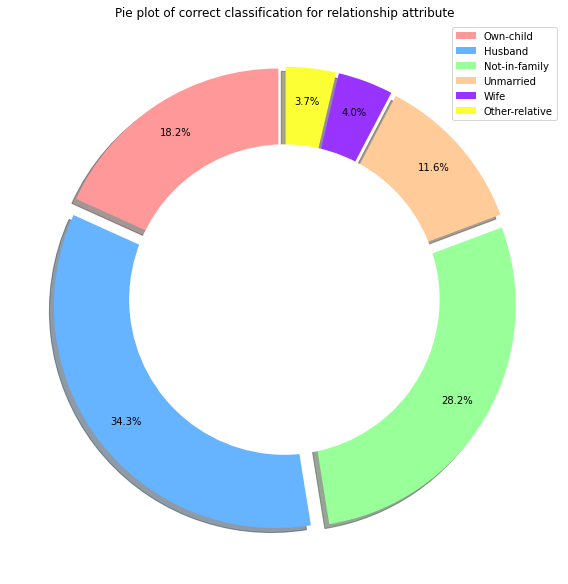

In [ ]:
pie_plot('relationship', Y_test, Y_pred)

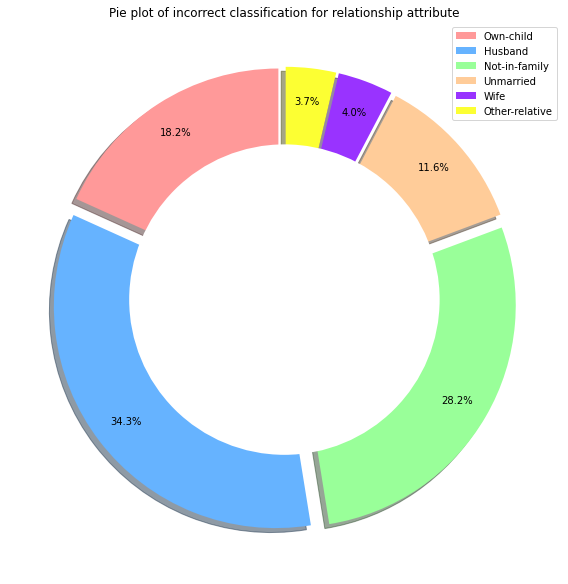

In [ ]:
pie_plot('relationship', Y_test, Y_pred, correct_class=False)

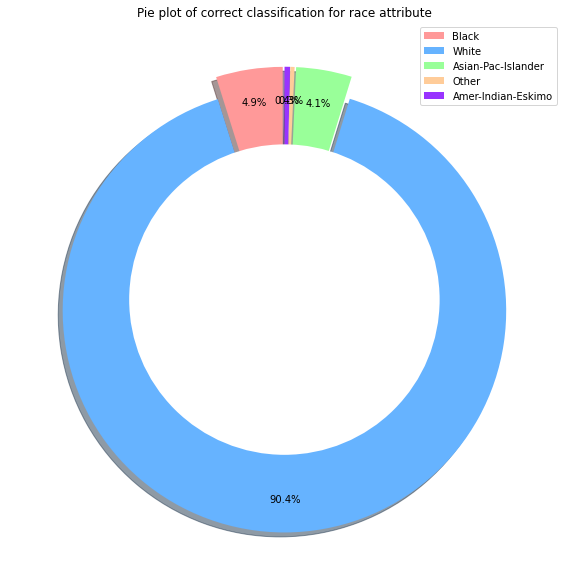

In [ ]:
pie_plot('race', Y_test, Y_pred, plot_type='positive')

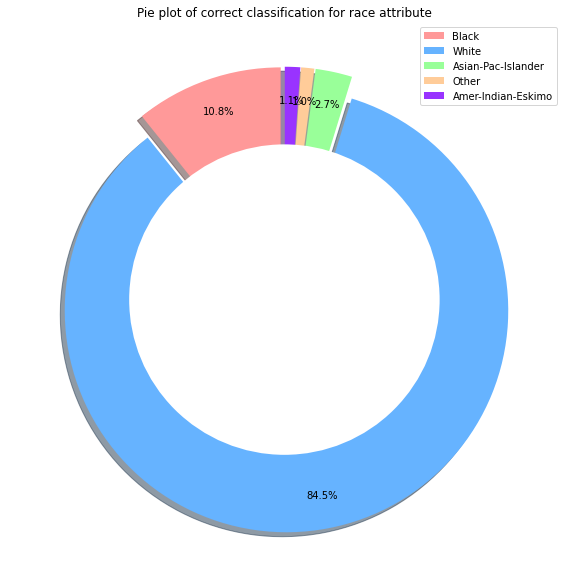

In [ ]:
pie_plot('race', Y_test, Y_pred, plot_type='negative')

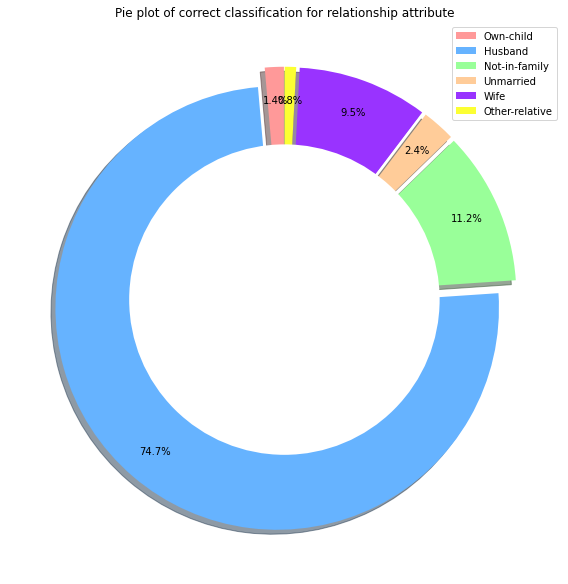

In [ ]:
pie_plot('relationship', Y_test, Y_pred, plot_type='positive')

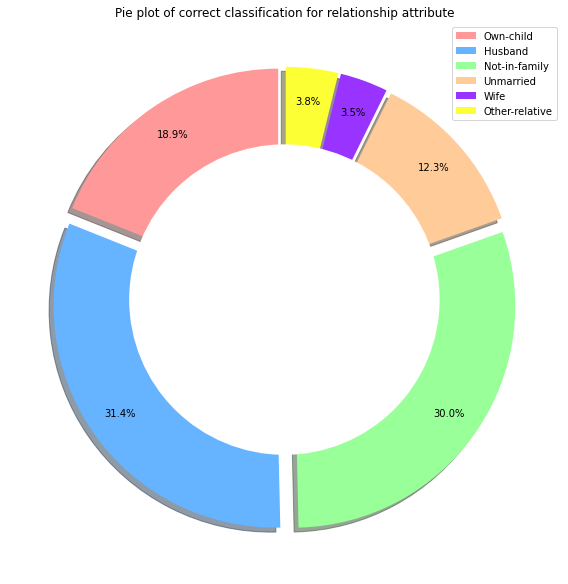

In [ ]:
pie_plot('relationship', Y_test, Y_pred, plot_type='negative')

## **Part 5: Conclusion**

It is clear from the results obtained of the census-income dataset that there exists bias and possible unfairness that can be attributed to some of the sensitive attributes. It was discovered that completely removing these sensitive attributes gave a slight decrease in classification accuracy to around ~79% whilist just removing the chosen race and relationship attributes gave a marginally better accracy of ~82%. Addiotnally, looking into the results, alongside the earlier exploratory analysis section, one can conclude that much of the existing bias and or effect sensitive attributes have on final classification, can be put down to the makeup of the dataset. The dataset is unbalanced in many ways, in terms of race, sex, relationship, marital-status and native-country, with some classes and invididuals being largely underrepresented in some attributes. Ultimatly this skew in the makeup of some attributes leads to possible individual and group fairness issues, as was highlighted in Part 4. Further investigation found that that ....

## **References**

[1] - Census Income Dataset. UC Irvine Machine Learning Repository. Available from: https://archive.ics.uci.edu/ml/datasets/census+income

[2] - Ron Kohavi. 1996. Scaling up the accuracy of Naive-Bayes classifiers: a decision-tree hybrid. In Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (KDD'96). AAAI Press, 202–207.

[3] - Tune Hyperparameters for Classification Machine Learning Algorithms. Machine Learning Mastery. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

[4] - Understanding Random Forest. Tony Yiu. Published June, 2019. https://towardsdatascience.com/understanding-random-forest-58381e0602d2. Accessed 12/02/21.

[5] - Prediction of income with 98% accuracy on adult dataset. Kaggle. https://www.kaggle.com/jilkothari/prediction-of-income-with-98-accuracy

[6] – A tutorial on fairness in machine learning. Ziyuan Zhong. Published Oct 2018.
https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb. Accessed 17/02/21.

